# Selecting 100 core skills for upskilling

We leveraged the ESCO framework of skills and our job transition recommendation algorithm to measure the effect of adding a single skill to a worker’s range of transition options. Here, we find 100 core
skills items that reflect the central competencies for a large
number of occupations and which, therefore, would be
expected to have a positive impact on workers’ career
prospects. Later on, in `Upskilling_02_Analysis.iypnb` we demonstrate the effect of each of these skills, when they are added, one at a time, to the at-risk workers’ skills set.

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble_Transitions.ipy
import os

data = load_data.Data()
sims = load_data.Similarities()

In [2]:
import mapping_career_causeways.cluster_utils as cluster_utils
import mapping_career_causeways.plotting_utils as plot_utils

# 1. Select skills to analyse further

For checking, we will select the top-100 most central or "core" skills (that include all *skills*, *knowledge* and *attitudes*). It is perhaps interesting to especially highlight knowledge and attitudes, as these in theory do not require experience but can be adopted or learned, respectively.

## 1.1 Calculate the global 'coreness' of all skills

In [3]:
# Create bipartite adjecency matrix for occupations and skills
A = np.zeros((len(data.occ), len(data.skills)))
for i, row in data.node_to_all_items.iterrows():
    A[row.id, row.items_list] = 1    
print(A.shape)

# Co-occurrence matrix
W = np.dot(A.T,A)
np.fill_diagonal(W,0)
print(W.shape)

# Adjacency matrix of the co-occurrence graph
A = np.zeros(W.shape)
A[W!=0] = 1

(2942, 13485)
(13485, 13485)


In [4]:
graph = cluster_utils.build_graph(W, A)

Building the graph... done!


In [5]:
## Calculate 'coreness' (might take a few minutes)

# Eigenvector centrality, e
centrality_unweighted = graph.evcent(directed=False, scale=True, weights=None)
# Betweenness centrality, b
betweenness = graph.betweenness(directed=False)
# Clustering coefficient, c
clustering_coeff = graph.transitivity_local_undirected()
# Normalise betweenness centrality between 0 and 1, b_norm
betweenness_norm = np.array(betweenness) / np.max(betweenness)
# Average b_norm and e
mean_centrality = 0.5*np.array(betweenness_norm) + 0.5*np.array(centrality_unweighted)
# Multiply averaged centarlity with (1-c) to select skills that are high on both measures
m = mean_centrality*(1-np.array(clustering_coeff))
# Deal with nulls
m[np.where(np.isnan(m))[0]] = 0
# Normalise between 0 and 1
m = m / np.max(m)


In [6]:
skills = data.skills.copy()
skills['coreness'] = m

## 1.2 General observations

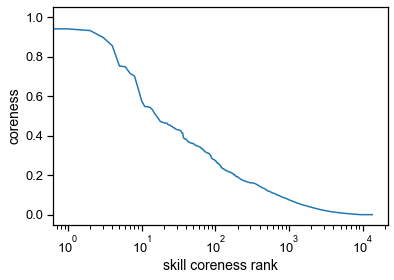

In [7]:
sns.lineplot(x=list(range(len(m))), y=np.flip(np.sort(m)))
plt.xlabel('skill coreness rank')
plt.ylabel('coreness')
plt.xscale('log')

In [8]:
skills.sort_values('coreness', ascending=False).head(25)[[
    'preferred_label', 'reuse_level', 'coreness']]


,preferred_label,reuse_level,coreness
3475,use different communication channels,cross-sector,1.000000
12026,train employees,cross-sector,0.939861
2778,manage staff,cross-sector,0.931311
1776,manage budgets,cross-sector,0.896653
710,communicate with customers,cross-sector,0.854498
160,create solutions to problems,cross-sector,0.751922
7753,write work-related reports,cross-sector,0.748190
7508,quality standards,cross-sector,0.713978
5558,identify customer's needs,sector-specific,0.701307
12672,liaise with managers,cross-sector,0.636548


## 1.3 Coreness measure's correspondence to the ESCO expert 'reuse' labels

['sector-specific' 'occupation-specific' 'cross-sector' 'transversal']


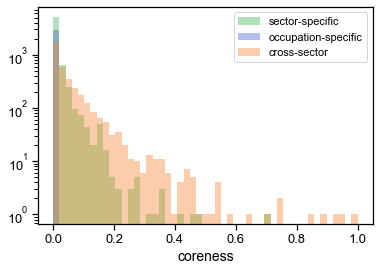

In [9]:
reuse_labels = skills.reuse_level.unique()
print(reuse_labels)

kde=False
for i, reuse_label in enumerate(reuse_labels[0:3]):
    sns.distplot(skills[skills.reuse_level==reuse_label].coreness,
                 kde=kde, label=reuse_label,
                 bins=np.linspace(0,1,50), color=plot_utils.colour_pal[i+1])
plt.legend()
plt.yscale('log')
plt.show()

## 1.4 Export tables

### All skills' coreness measures

In [10]:
skills_export = skills[['id', 'preferred_label', 'reuse_level', 'code', 'skill_category', 'coreness']]
skills_export.to_csv(data_folder + 'interim/upskilling_analysis/skills_coreness_measure.csv', index=False)

In [11]:
skills_export.sort_values('coreness')

,id,preferred_label,reuse_level,code,skill_category,coreness
6742,6742,control games,occupation-specific,S1.14.3,S,0.000000
8733,8733,Montessori learning equipment,occupation-specific,K1.0.4,K,0.000000
8735,8735,IBM WebSphere,sector-specific,K6.0.3,K,0.000000
3507,3507,share good practices across subsidiaries,cross-sector,S1.2.0,S,0.000000
8739,8739,perform child welfare investigations,sector-specific,S2.1.1,S,0.000000
...,...,...,...,...,...,...
710,710,communicate with customers,cross-sector,S3.4.1,S,0.854498
1776,1776,manage budgets,cross-sector,S4.3.1,S,0.896653
2778,2778,manage staff,cross-sector,S4.8.1,S,0.931311
12026,12026,train employees,cross-sector,S1.3.3,S,0.939861


### Top 100 core skills to test for upskilling

In [12]:
# Select the top 100 core skills
skills_top100 = skills_export.sort_values('coreness', ascending=False).head(100)
skills_top100.groupby('skill_category').count()[['id']]

,id
skill_category,
A,3
K,30
S,67


In [13]:
for j, row in skills_top100.iterrows():
    print(f"{row.coreness:.3f}, {row.preferred_label}")

1.000, use different communication channels
0.940, train employees
0.931, manage staff
0.897, manage budgets
0.854, communicate with customers
0.752, create solutions to problems
0.748, write work-related reports
0.714, quality standards
0.701, identify customer's needs
0.637, liaise with managers
0.577, perform project management
0.547, mechanics
0.546, troubleshoot
0.542, adhere to organisational guidelines
0.532, recruit employees
0.512, build business relationships
0.498, have computer literacy
0.484, wear appropriate protective gear
0.471, monitor stock level
0.468, apply health and safety standards
0.465, develop professional network
0.463, manage contracts
0.463, ensure equipment availability
0.455, scientific research methodology
0.455, project management
0.448, present reports
0.446, perform risk analysis
0.440, use a computer
0.439, apply technical communication skills
0.433, keep records of work progress
0.431, speak different languages
0.430, chemistry
0.428, supervise staf

In [14]:
skills_top100.to_csv(data_folder + 'interim/upskilling_analysis/skills_top100_core.csv', index=False)
skills_top100

,id,preferred_label,reuse_level,code,skill_category,coreness
3475,3475,use different communication channels,cross-sector,S1.2.1,S,1.000000
12026,12026,train employees,cross-sector,S1.3.3,S,0.939861
2778,2778,manage staff,cross-sector,S4.8.1,S,0.931311
1776,1776,manage budgets,cross-sector,S4.3.1,S,0.896653
710,710,communicate with customers,cross-sector,S3.4.1,S,0.854498
...,...,...,...,...,...,...
8306,8306,mechanical engineering,sector-specific,K7.1.5,K,0.279339
3893,3893,ensure public safety and security,sector-specific,S3.3.0,S,0.279087
8393,8393,keep personal administration,sector-specific,S2.2.5,S,0.277491
4921,4921,contract law,cross-sector,K4.2.0,K,0.276277
